Training set size: 35918
Test set size: 8980

Top words in Fake news: ['america' 'com' 'white' 'news' 'twitter' 'donald' 'like' 'said' 'just'
 'hillary' 'president' 'obama' 'people' 'clinton' 'trump']
Top words in Real news: ['senate' 'told' 'north' 'new' 'states' 'united' 'republican' 'washington'
 'government' 'house' 'state' 'president' 'reuters' 'trump' 'said']
Accuracy: 0.9359688195991092

Classification report:

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4696
           1       0.93      0.94      0.93      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980


Confusion matrix:
[[4393  303]
 [ 272 4012]]


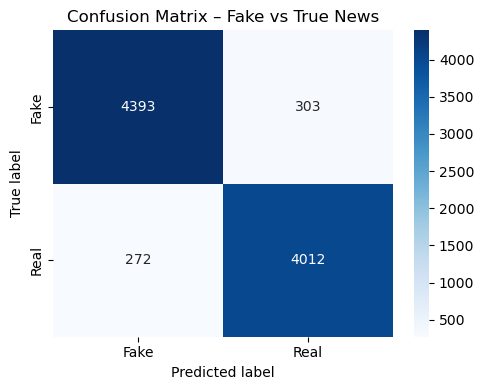

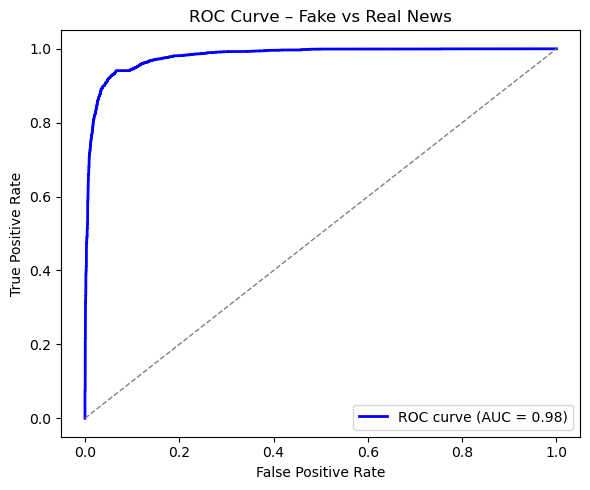


Enter a news snippet (or type 'exit' to quit):
 Russian personnel with links to the country’s military and security services have engaged in spying in European waters while working covertly on ships carrying Russian oil, Western and Ukrainian intelligence sources exclusively told CNN.  Since the full-scale invasion of Ukraine in 2022, Moscow has built up a so-called shadow fleet of hundreds of tankers. These vessels carry Russia’s oil from its Baltic and Black Sea ports despite Western sanctions, earning the Kremlin hundreds of millions of dollars every year.  In recent months, some of these ships – often registered to unrelated countries – have acquired extra crew members shortly before leaving port, according to Ukrainian intelligence. CNN has seen two crew lists for these vessels in which the staff is predominantly non-Russian – but the documents also feature a pair of Russian names, and their Russian passport details, at the bottom of the roster.  The addition of Russians with sec


Prediction: Real News


In [ ]:
# Libraries
import pandas as pd
import numpy as np
import unidecode
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Loading fake and real news
true_df = pd.read_csv("True.csv")
fake_df = pd.read_csv("Fake.csv")

# Label news as 1 or 0.
true_df["label"] = 1   # 1 = real
fake_df["label"] = 0   # 0 = fake

# Combine fake and true news in a single table
df = pd.concat([true_df, fake_df], axis=0, ignore_index=True)

# Save merged file
df.to_csv("merged_fake_real_news.csv", index=False)


# Functions
def clean_text(x):
    x = str(x).lower()
    x = unidecode.unidecode(x)
    return x

# Main
if __name__ == "__main__":

    # Load merged dataset
    df = pd.read_csv("merged_fake_real_news.csv")

    # Keep relevant columns
    df = df[["text", "label"]].dropna()

    # Clean text
    df["text_clean"] = df["text"].apply(clean_text)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        df["text_clean"],
        df["label"],
        test_size=0.2, # 20 % of total dataset
        random_state=42,
        stratify=df["label"]
    )

    # Print dataset sizes
    print("Training set size:", X_train.shape[0])
    print("Test set size:", X_test.shape[0])
    
    # Vectorization (NLP feature extraction)
    vectorizer = TfidfVectorizer(
        stop_words="english",
        max_df=0.9,
        min_df=5
    )

    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Initialize classifier
    classifier = MultinomialNB()

    # Train model
    classifier.fit(X_train_tfidf, y_train)

    # Predict
    y_pred = classifier.predict(X_test_tfidf)

    # Top words per class

    feature_names = np.array(vectorizer.get_feature_names_out())
    fake_idx = classifier.feature_log_prob_[0].argsort()[-15:]
    real_idx = classifier.feature_log_prob_[1].argsort()[-15:]

    print("\nTop words in Fake news:", feature_names[fake_idx])
    print("Top words in Real news:", feature_names[real_idx])


    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Fake", "Real"],
    yticklabels=["Fake", "Real"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Fake vs True News")
plt.tight_layout()
plt.savefig("Confusion Matrix.png")
plt.show()


# %% ROC-AUC Curve

# Get predicted probabilities for the positive class (Real news)
y_prob = classifier.predict_proba(X_test_tfidf)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Fake vs Real News')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("ROC AUC Curve.png")
plt.show()

# User Input Prediction
def predict_news(text_input):
    """
    Predict if the given news snippet is Fake or Real.
    """
    # Step 1: Clean the text (same preprocessing as training)
    text_clean = unidecode.unidecode(str(text_input).lower())
    
    # Step 2: Transform using the trained TF-IDF vectorizer
    text_tfidf = vectorizer.transform([text_clean])
    
    # Step 3: Predict using the trained classifier
    pred_label = classifier.predict(text_tfidf)[0]
    
    # Step 4: Map numeric label to string
    if pred_label == 1:
        return "Real News"
    else:
        return "Fake News"

# %% Interactive user input
if __name__ == "__main__":
    while True:
        user_input = input("\nEnter a news snippet (or type 'exit' to quit):\n")
        if user_input.lower() == "exit":
            print("Exiting the program.")
            break
        result = predict_news(user_input)
        print(f"\nPrediction: {result}")